In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd 
import wandb
import yaml
import numpy as np
import seaborn as sns
from tqdm import tqdm
from functools import cache
from matplotlib.ticker import ScalarFormatter

palette = sns.color_palette('Set2', 4)
sns.set(context='paper', 
        style='ticks', 
        palette=palette,
        font='Linux Libertine O', 
        font_scale=2.5, 
        rc={
            'mathtext.fontset': 'stix',
            'lines.linewidth' : 4,
            'lines.markersize' : 12,
        }
)
sns.despine()
os.makedirs('figs', exist_ok=True)

<Figure size 640x480 with 0 Axes>

In [3]:
@cache
def load_dataset(dataset_name: str):
    from core.datasets.loader import DatasetLoader
    data = DatasetLoader(dataset_name).load(verbose=False)
    return data

def get_dp_level(method: str):
    if method.endswith('-$\infty$'): return 'none'
    if method.endswith('-EDP'): return 'edge'
    if method.endswith('-NDP'): return 'node'
    if method == 'MLP': return 'edge'
    if method == 'MLP-DP': return 'node'

def generate_noisy_values(df, metric_mean, metric_ci, num_samples=1000):
    df['noise'] = [np.random.randn(num_samples)] * len(df)
    df['noise'] = df['noise'] * df[metric_ci]
    df = df.explode(column='noise')
    df = df.reset_index(drop=True)
    df[metric_mean] += df['noise']
    return df

In [4]:
with open('config/wandb.yaml') as f:
    wandb_config = yaml.safe_load(f)

api = wandb.Api()
runs = api.runs(f"{wandb_config['username']}/{wandb_config['project']['train']}", per_page=2000)

i = 0
data_list = []

for run in tqdm(runs): 
    data = {}
    data.update(run.summary._json_dict)
    data.update(run.config)
    data['id'] = i
    data['run'] = run
    data['method'] = data['method'].upper().replace('INF', '$\infty$').replace('PRO', 'Pro')    
    data_list.append(data)
    i += 1


100%|██████████| 3460/3460 [00:03<00:00, 1142.53it/s]


# Dataset Statistics

In [8]:
datasets = ['facebook', 'reddit', 'amazon', 'facebook-100', 'wenet']
records = []

for dataset in tqdm(datasets, desc='loading datasets'):
    data = load_dataset(dataset)
    nodes_degree = data.adj_t.to_sparse_coo().sum(dim=1).to_dense() # in degree
    records.append({
        'dataset': dataset,
        'nodes': data.num_nodes,
        'edges': data.num_edges,
        'features': data.num_features,
        'classes': int(data.y.max() + 1),
        'median degree': int(nodes_degree.median()),
    })

df = pd.DataFrame(records)
# df.sort_values('nodes', inplace=True)
df = df.applymap(lambda x: f'{x:,}' if isinstance(x, int) else x)
print(df.to_latex(index=False))
df

loading datasets: 100%|██████████| 5/5 [00:00<00:00, 192.59it/s]

\begin{tabular}{llllll}
\toprule
     dataset &     nodes &      edges & features & classes & median degree \\
\midrule
    facebook &    26,406 &  2,117,924 &      501 &       6 &            62 \\
      reddit &   116,713 & 46,233,380 &      602 &       8 &           209 \\
      amazon & 1,790,731 & 80,966,832 &      100 &      10 &            22 \\
facebook-100 & 1,120,280 & 86,304,478 &      537 &       6 &            57 \\
       wenet &    37,576 & 22,684,206 &       44 &       4 &           286 \\
\bottomrule
\end{tabular}



,dataset,nodes,edges,features,classes,median degree
0,facebook,"26,406","2,117,924",501,6,62
1,reddit,"116,713","46,233,380",602,8,209
2,amazon,"1,790,731","80,966,832",100,10,22
3,facebook-100,"1,120,280","86,304,478",537,6,57
4,wenet,"37,576","22,684,206",44,4,286


# Trade-offs between Privacy and Accuracy

### Main results

In [7]:
cols = ['id', 'method', 'dataset', 'epsilon', 'layerwise', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci', 'run']
methods = ['ProGAP-$\infty$', 'GAP-$\infty$', 'ProGAP-EDP', 'GAP-EDP', 'ProGAP-NDP', 'GAP-NDP']
datasets = ['facebook', 'reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods')
df['dp_level'] = df['method'].apply(get_dp_level)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['dp_level'] == 'none', 'epsilon'] = np.inf
df = df.query('dp_level != "edge" or epsilon in [0,1]')
df = df.query('dp_level != "node" or epsilon == 8')
df = df.query('not method.str.startswith("ProGAP") or layerwise == False')

idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

# df_url = df.drop(columns=['id', 'train/acc_mean', 'val/acc_mean', 'test/acc_ci', 'layerwise', 'dp_level'])
# print(df_url)

df['acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.2f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1
)
df = df.drop(columns=['id', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci', 'layerwise'])

def sort_key(row):
    keys = {
        **{k:v+1 for v,k in enumerate(datasets)},     # datasets
        'ProGAP-$\infty$': 1, 'GAP-$\infty$': 2, 'ProGAP-EDP': 3, 'GAP-EDP': 4, 'MLP': 5, 'ProGAP-NDP': 6, 'GAP-NDP': 7, 'MLP-DP': 8,  # methods
        'none': 1, 'edge': 2, 'node': 3,  # levels
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df = df.sort_values(by=['dataset', 'dp_level', 'method'], key=sort_key)
pd.options.display.width = 1000
pd.options.display.max_colwidth = 1000
df['run'] = df['run'].apply(lambda x: x.url)
# print(df.query('method.str.startswith("ProGAP")').drop(columns=['dp_level', 'acc']))
df = df.pivot(columns='dataset', index=['dp_level', 'method', 'epsilon'], values='acc')
df = df.reset_index().sort_values(
    by=['dp_level', 'method'],
    key=sort_key
).set_index(['dp_level', 'method', 'epsilon'])
df = df.sort_index(axis=1, key=sort_key)
df = df.rename(str.title, axis=1)
df = df.rename(str.title, axis=0, level=0)
df = df.rename_axis(index={'dp_level': 'Privacy Level', 'epsilon': 'privacy cost'})
df = df.rename_axis(index=str.title)
df = df.rename_axis(columns=str.title)
df = df.rename({np.inf: '$\infty$'}, axis=0, level=2)
# print(df.style.to_latex())
df

Dataset                                            Facebook           Reddit           Amazon     Facebook-100            Wenet
Privacy Level Method          Privacy Cost                                                                                     
None          ProGAP-$\infty$ $\infty$      84.5 $\pm$ 0.24  99.3 $\pm$ 0.00  93.4 $\pm$ 0.00  74.5 $\pm$ 0.00  74.2 $\pm$ 0.00
              GAP-$\infty$    $\infty$      80.5 $\pm$ 0.42  99.5 $\pm$ 0.01  92.0 $\pm$ 0.10  66.4 $\pm$ 0.35  69.7 $\pm$ 0.14
Edge          ProGAP-EDP      1.0           76.7 $\pm$ 0.00  97.8 $\pm$ 0.05  84.3 $\pm$ 0.00  56.9 $\pm$ 0.30  69.4 $\pm$ 0.00
              GAP-EDP         1.0           69.4 $\pm$ 0.39  97.5 $\pm$ 0.06  78.8 $\pm$ 0.26  46.5 $\pm$ 0.58  62.4 $\pm$ 0.28
Node          ProGAP-NDP      8.0           69.3 $\pm$ 0.33  93.9 $\pm$ 0.00  79.1 $\pm$ 0.10  49.1 $\pm$ 0.00  61.0 $\pm$ 0.34
              GAP-NDP         8.0           63.9 $\pm$ 0.49  93.9 $\pm$ 0.09  77.6 $\pm$ 0.07  43.0 $\pm$ 0.20  58.2 $\pm$ 0.39

In [8]:
cols = ['id', 'method', 'dataset', 'epsilon', 'layerwise', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci']
methods = ['ProGAP-$\infty$', 'ProGAP-EDP', 'ProGAP-NDP']
datasets = ['facebook', 'reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods')
df.loc[df['method'] == 'ProGAP-$\infty$', 'epsilon'] = np.inf
df = df.query('method != "ProGAP-EDP" or epsilon == 1')
df = df.query('method != "ProGAP-NDP" or epsilon == 8')

idx = df.groupby(['dataset', 'method', 'epsilon', 'layerwise'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.2f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1
)
df = df.drop(columns=['id', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci'])

def sort_key(row):
    keys = {
        **{k:v+1 for v,k in enumerate(datasets)},     # datasets
        'None-Private': 1, 'Edge-Level': 3, 'Node-Level': 6,  # methods
        'Progressive': 1, 'Layerwise': 2,  # layerwise
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df = df.sort_values(by=['dataset', 'method', 'layerwise'], key=sort_key)
df['Privacy Level'] = df['method'].apply(lambda x: {'ProGAP-$\infty$': 'None-Private', 'ProGAP-EDP': 'Edge-Level', 'ProGAP-NDP': 'Node-Level'}[x])
df['Approach'] = df['layerwise'].apply(lambda x: 'Layerwise' if x else 'Progressive')
df = df.drop(columns=['method', 'layerwise'])
df = df.pivot(columns='dataset', index=['Privacy Level', 'epsilon', 'Approach'], values='acc')
df = df.reset_index().sort_values(
    by=['Privacy Level', 'Approach'],
    key=sort_key
).set_index(['Privacy Level', 'epsilon', 'Approach'])
df = df.sort_index(axis=1, key=sort_key)
df = df.rename(str.title, axis=1)
df = df.rename(str.title, axis=0, level=0)
df = df.rename_axis(index={'epsilon': 'privacy cost'})
df = df.rename_axis(index=str.title)
df = df.rename_axis(columns=str.title)
df = df.rename({np.inf: '$\infty$'}, axis=0, level=2)
# print(df.style.to_latex())
df

Dataset                                        Facebook           Reddit           Amazon     Facebook-100            Wenet
Privacy Level Privacy Cost Approach                                                                                        
None-Private  inf          Progressive  84.5 $\pm$ 0.24  99.3 $\pm$ 0.00  93.4 $\pm$ 0.00  74.5 $\pm$ 0.00  74.2 $\pm$ 0.00
                           Layerwise    85.6 $\pm$ 0.29  99.4 $\pm$ 0.02  92.9 $\pm$ 0.04  74.0 $\pm$ 0.16  71.9 $\pm$ 0.19
Edge-Level    1.0          Progressive  76.7 $\pm$ 0.00  97.8 $\pm$ 0.05  84.3 $\pm$ 0.00  56.9 $\pm$ 0.30  69.4 $\pm$ 0.00
                           Layerwise    76.8 $\pm$ 0.22  98.0 $\pm$ 0.06  83.4 $\pm$ 0.08  55.7 $\pm$ 0.25  67.7 $\pm$ 0.25
Node-Level    8.0          Progressive  69.3 $\pm$ 0.33  93.9 $\pm$ 0.00  79.1 $\pm$ 0.10  49.1 $\pm$ 0.00  61.0 $\pm$ 0.34
                           Layerwise    68.7 $\pm$ 0.48  94.0 $\pm$ 0.07  78.8 $\pm$ 0.05  49.2 $\pm$ 0.57  59.3 $\pm$ 0.42

## Edge-level DP

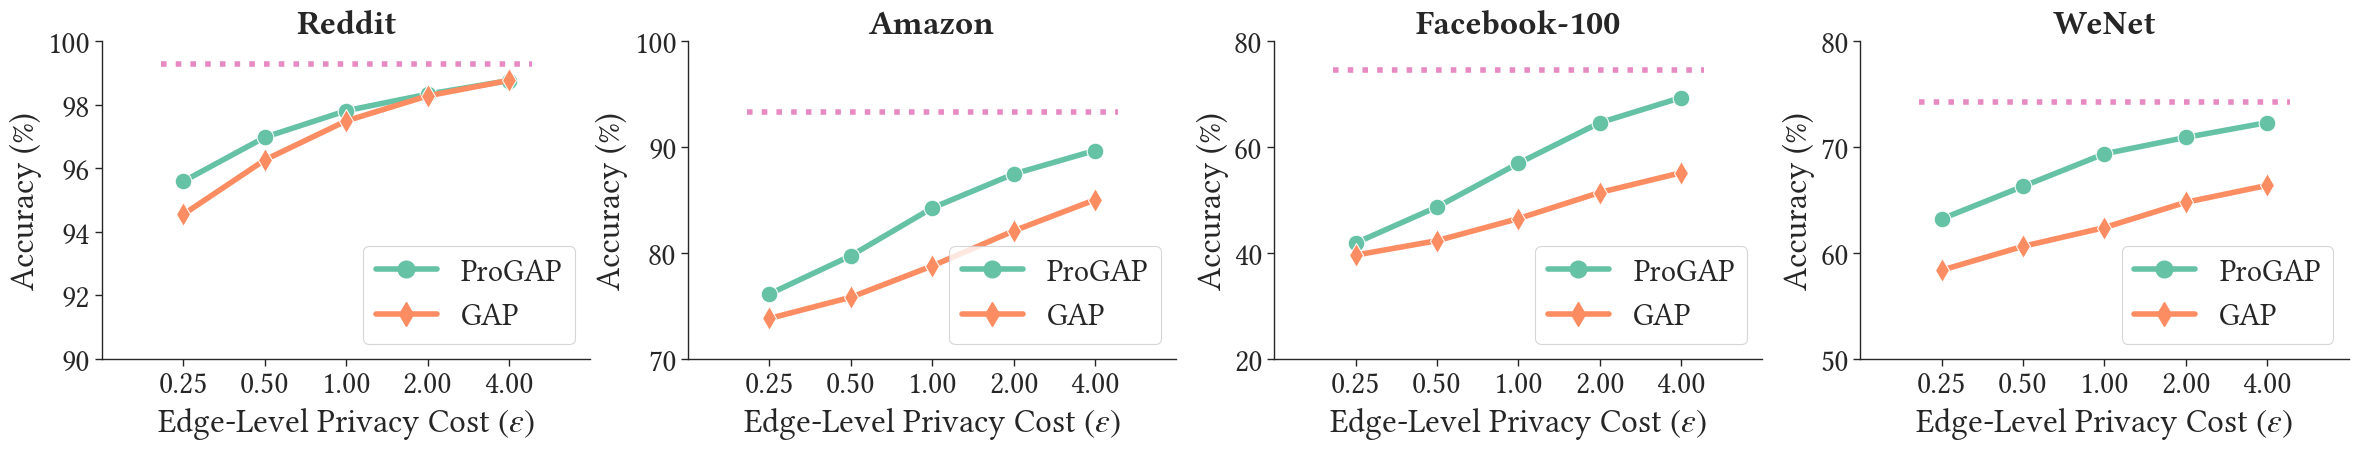

In [9]:
cols = ['id', 'method', 'dataset', 'epsilon', 'layerwise', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-$\infty$', 'ProGAP-EDP', 'GAP-EDP']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']
epsilons = [0.25, 0.5, 1, 2, 4]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'MLP', 'epsilon'] = 0
df.loc[df['method'] == 'ProGAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[0,np.inf])]
df = df.query('not method.str.startswith("ProGAP") or layerwise == False')

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

inf_acc = df.loc[df['method'] == 'ProGAP-$\infty$', ['dataset', 'test/acc_mean']].set_index('dataset')
# mlp_acc = df.loc[df['method'] == 'MLP', ['dataset', 'test/acc_mean']].set_index('dataset')
edp_methods = ['ProGAP-EDP', 'GAP-EDP']
df = df.loc[df['method'].isin(edp_methods)]
df = df.sort_values(by='method')

# plot
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=['o', 'd'], dashes=False, style='method',
                hue_order=edp_methods, col_order=datasets, style_order=edp_methods,
                facet_kws={'sharey': False, 'sharex': False})

g.set(ylabel='Accuracy (%)', xlabel='Edge-Level Privacy Cost $(\epsilon)$', xscale='log', xticks=epsilons, xlim=(epsilons[0] / 2, epsilons[-1] * 2))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', color=palette[3], xmin=0.12, xmax=0.88)
    # ax.axhline(mlp_acc.loc[dataset].item(), linestyle='dashed', label='MLP', color=palette[2], xmin=0.12, xmax=0.88)
    ax.set_title(label='WeNet' if dataset == 'wenet' else dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        loc='lower right', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=[legend_data[method] for method in edp_methods], 
        labels=[method.replace('-EDP', '') for method in edp_methods])
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.axes[0][0].set_ylim(90, 100)
g.axes[0][1].set_ylim(70, 100)
g.axes[0][2].set_ylim(20, 80)
g.axes[0][3].set_ylim(50, 80)
# g.fig.set_figwidth(16)
g.savefig('figs/tradeoff-edge.pdf')

## Node-level DP

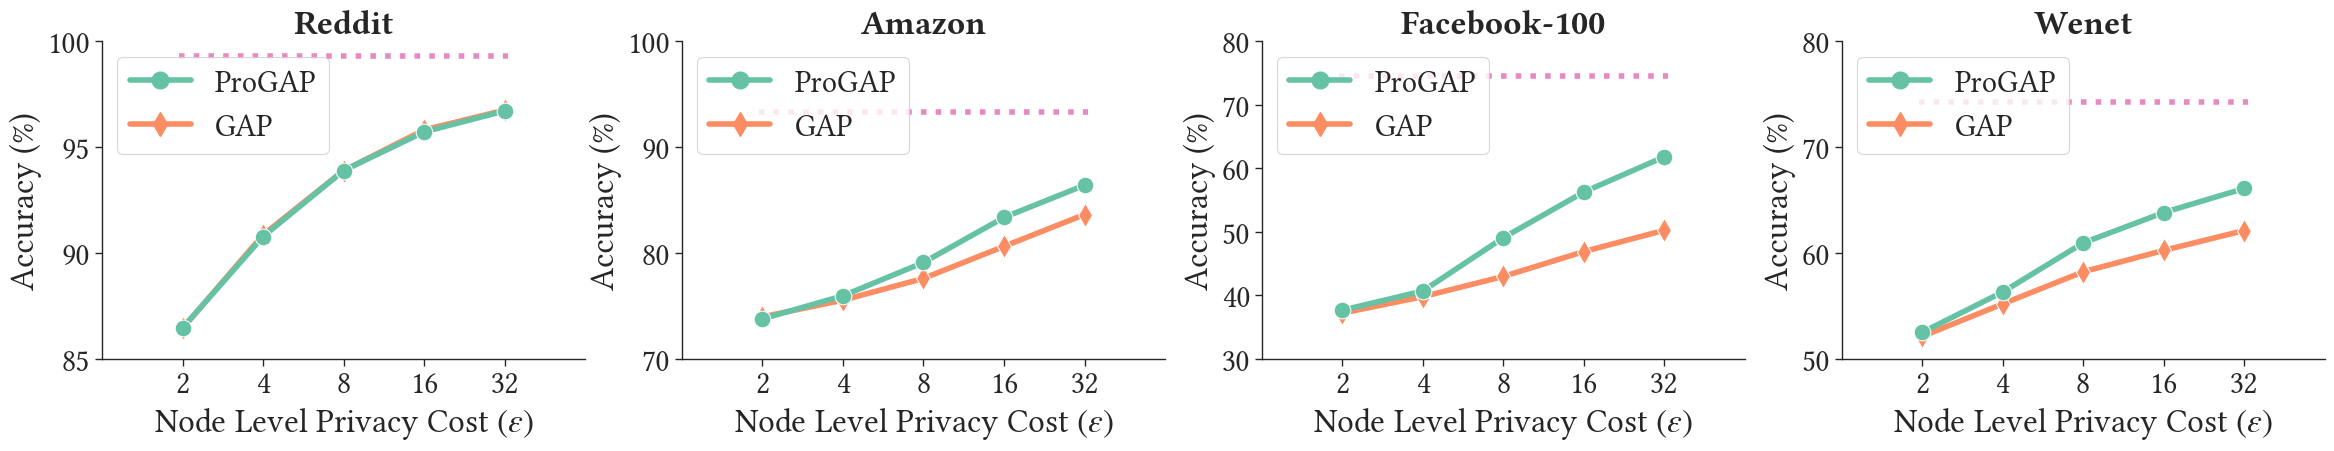

In [8]:
cols = ['id', 'method', 'dataset', 'epsilon', 'layerwise', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-$\infty$', 'ProGAP-NDP', 'GAP-NDP']
datasets = datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']
epsilons = [2, 4, 8, 16, 32]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['method'] == 'ProGAP-$\infty$', 'epsilon'] = np.inf
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons+[np.inf])]
df = df.query('not method.str.startswith("ProGAP") or layerwise == False')

# select best models based on valication accuracy
# df.loc[df['method'] == 'SAGE-NDP', 'val/acc_mean'] = df.loc[df['method'] == 'SAGE-NDP', 'train/acc_mean'] # validation is disabled for SAGE-NDP
idx = df.groupby(['dataset', 'method', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

inf_acc = df.loc[df['method'] == 'ProGAP-$\infty$', ['dataset', 'test/acc_mean']].set_index('dataset')
ndp_methods = ['GAP-NDP', 'ProGAP-NDP']
df = df.loc[df['method'].isin(ndp_methods)]
df['epsilon'] = df['epsilon'].astype(int)

# plot
# palette = sns.color_palette()
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=['d', 'o'], dashes=False, style='method',
                hue_order=ndp_methods, col_order=datasets, style_order=ndp_methods,
                palette=[palette[1], palette[0]],
                facet_kws={'sharey': False, 'sharex': False})

g.set(ylabel='Accuracy (%)', xlabel='Node Level Privacy Cost $(\epsilon)$', xscale='log', xticks=epsilons, xlim=(epsilons[0] / 2, epsilons[-1] * 2))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', label='ProGAP-$\infty$', color=sns.color_palette('Set2')[3], xmin=0.16, xmax=0.84)
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        loc='upper left', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=[legend_data[method] for method in ndp_methods[::-1]], 
        labels=[method.replace('-NDP', '') for method in ndp_methods[::-1]])
g.axes[0][0].set_ylim(85, 100)
g.axes[0][1].set_ylim(70, 100)
g.axes[0][2].set_ylim(30, 80)
g.axes[0][3].set_ylim(50, 80)
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.fig.set_figwidth(16)
g.savefig('figs/tradeoff-node.pdf')

# Effect of the number of stages

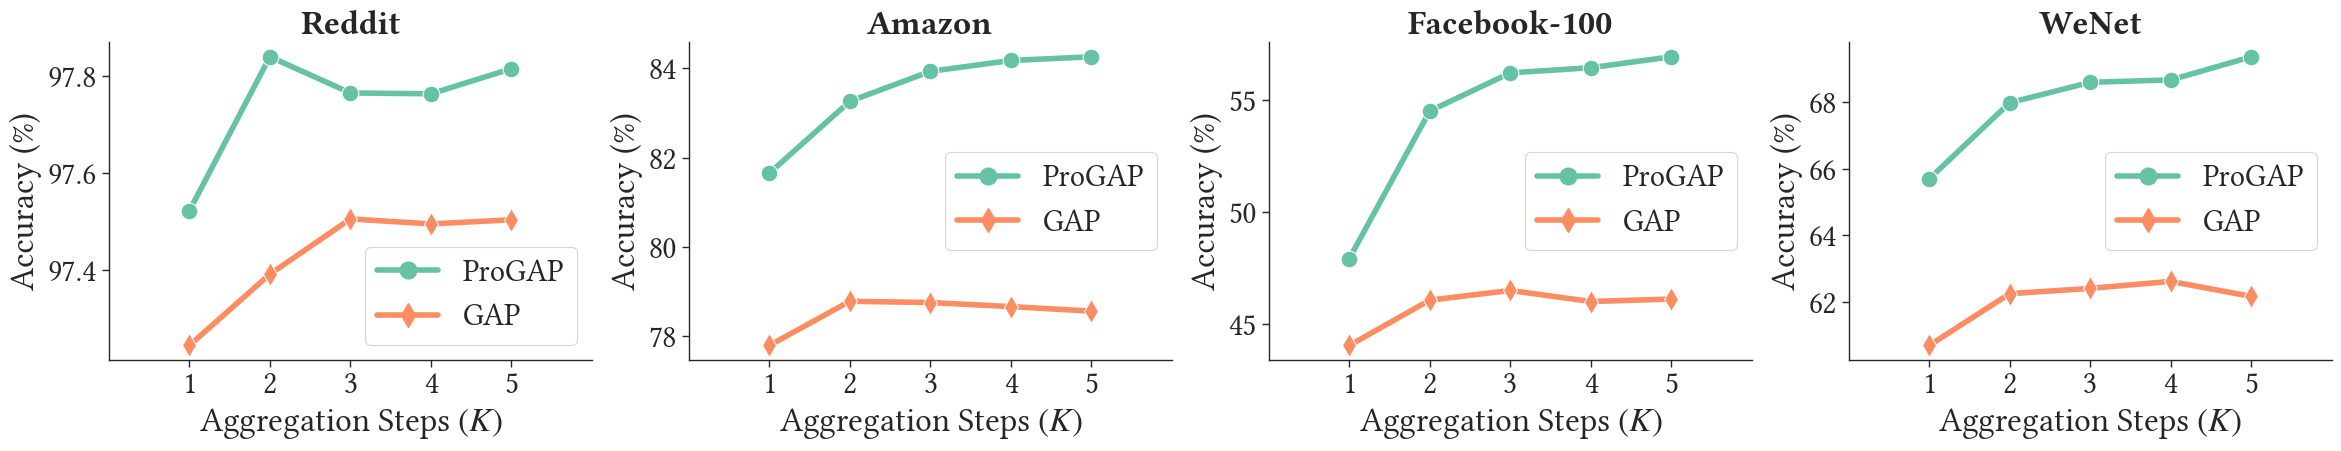

In [9]:
cols = ['id', 'method', 'dataset', 'epsilon', 'layerwise', 'stages', 'hops', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-EDP', 'GAP-EDP']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods')
df['K'] = df['stages'].apply(lambda x: x - 1 if not pd.isna(x) else 0)
df['K'] += df['hops'].apply(lambda x: x if not pd.isna(x) else 0)
df = df.query('epsilon == 1')
df = df.query('not method.str.startswith("ProGAP") or layerwise == False')

idx = df.groupby(['dataset', 'method', 'epsilon', 'K'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['acc'] = df['test/acc_mean']
df = df.drop(columns=['id', 'val/acc_mean', 'test/acc_mean', 'stages', 'hops', 'layerwise'])


g = sns.relplot(kind='line', data=df, x='K', y='acc', hue='method', col='dataset', aspect=1.2,
                markers=['o', 'd'], dashes=False, style='method',
                hue_order=methods, col_order=datasets, style_order=methods,
                facet_kws={'sharey': False, 'sharex': False})

g.set(ylabel='Accuracy (%)', xlabel='Aggregation Steps $(K)$', xticks=range(1,6), xlim=(0, 6))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label='WeNet' if dataset == 'wenet' else dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        # loc='lower right', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=[legend_data[method] for method in methods], 
        labels=[method.replace('-EDP', '') for method in methods])
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.axes[0][0].set_ylim(90, 100)
# g.axes[0][1].set_ylim(70, 100)
# g.axes[0][2].set_ylim(20, 80)
# g.axes[0][3].set_ylim(50, 80)
# g.fig.set_figwidth(16)
# g.savefig('figs/edge.pdf')

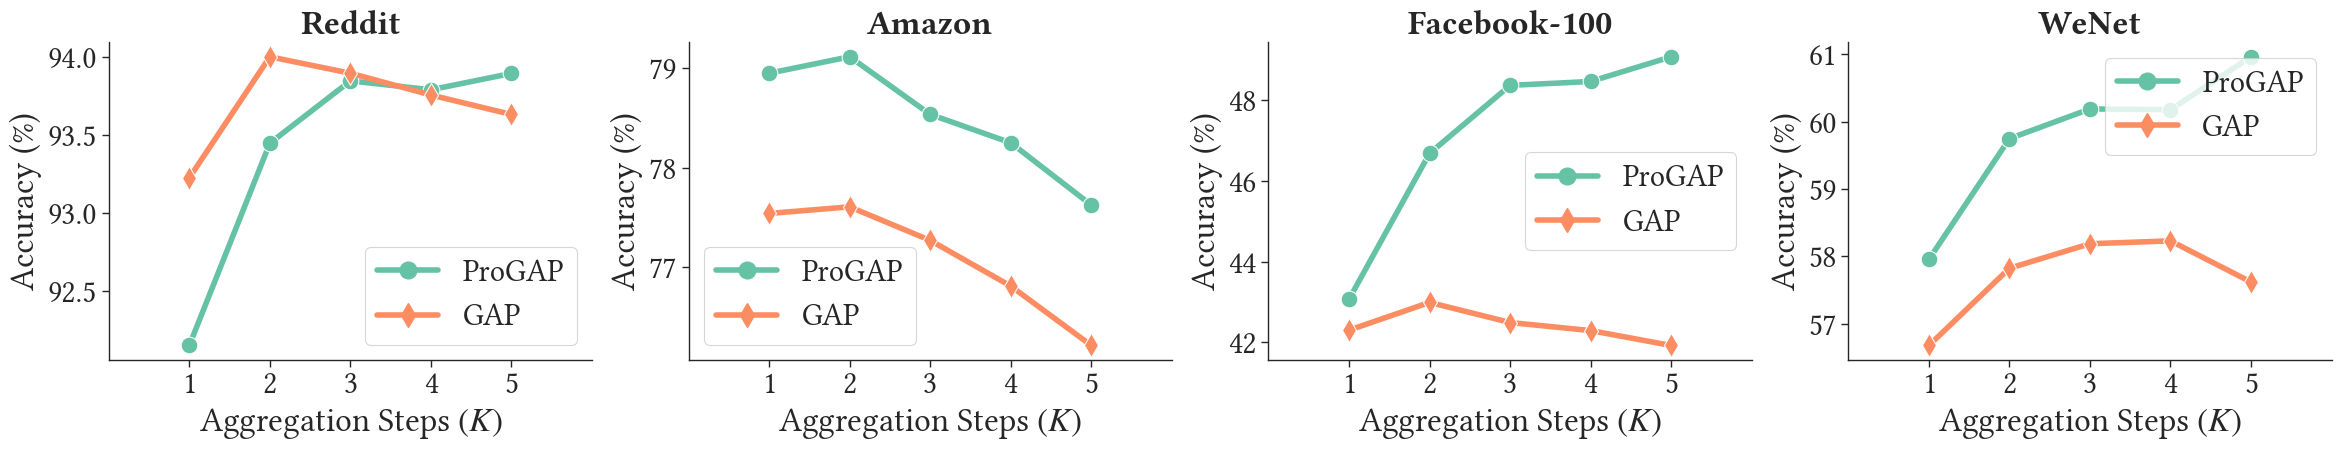

In [10]:
cols = ['id', 'method', 'dataset', 'epsilon', 'layerwise', 'stages', 'hops', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-NDP', 'GAP-NDP']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods')
df['K'] = df['stages'].apply(lambda x: x - 1 if not pd.isna(x) else 0)
df['K'] += df['hops'].apply(lambda x: x if not pd.isna(x) else 0)
df = df.query('epsilon == 8')
df = df.query('not method.str.startswith("ProGAP") or layerwise == False')

idx = df.groupby(['dataset', 'method', 'epsilon', 'K'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['acc'] = df['test/acc_mean']
df = df.drop(columns=['id', 'val/acc_mean', 'test/acc_mean', 'stages', 'hops', 'layerwise'])


g = sns.relplot(kind='line', data=df, x='K', y='acc', hue='method', col='dataset', aspect=1.2,
                markers=['o', 'd'], dashes=False, style='method',
                hue_order=methods, col_order=datasets, style_order=methods,
                facet_kws={'sharey': False, 'sharex': False})

g.set(ylabel='Accuracy (%)', xlabel='Aggregation Steps $(K)$', xticks=range(1,6), xlim=(0, 6))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label='WeNet' if dataset == 'wenet' else dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        # loc='lower right', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=[legend_data[method] for method in methods], 
        labels=[method.replace('-NDP', '') for method in methods])
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.axes[0][0].set_ylim(90, 100)
# g.axes[0][1].set_ylim(70, 100)
# g.axes[0][2].set_ylim(20, 80)
# g.axes[0][3].set_ylim(50, 80)
# g.fig.set_figwidth(16)
# g.savefig('figs/edge.pdf')

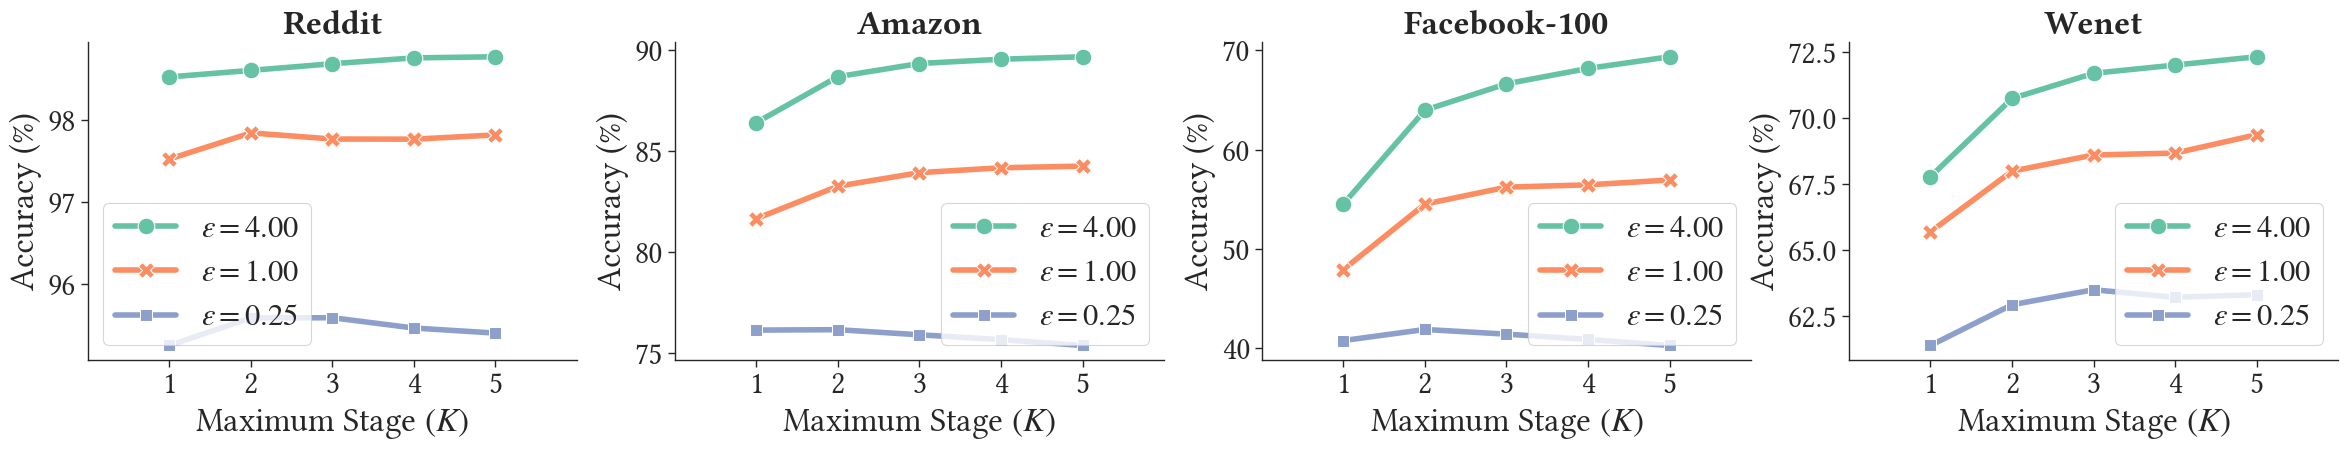

In [18]:
cols = ['method', 'dataset', 'epsilon', 'stages', 'layerwise', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-EDP']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']
epsilons = [0.25, 1, 4]

# epsilons_ndp = [4,16]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons)]
df = df.query('layerwise == False')
df['stages'] -= 1

# select best models based on valication accuracy
idx = df.groupby(['method', 'dataset', 'epsilon', 'stages'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
df['epsilon'] = df['epsilon']#.astype(int).astype(str)
df['style'] = df['method'].str.cat(df['epsilon'].astype(str), sep='-')

g = sns.relplot(kind='line', data=df, hue='style', y='test/acc_mean', x='stages', col='dataset', aspect=1.2,
                col_order=datasets, row_order=methods, markers=True, dashes=False, style='style', legend=False,
                facet_kws={'sharey': False, 'sharex': False}, errorbar=None)

g.set(ylabel='Accuracy (%)', xlabel='Maximum Stage $(K)$', xlim=(0,6), xticks=range(1,6))
for method, axes in zip(methods, g.axes):
    for dataset, ax in zip(datasets, axes):
        ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
        ax.legend(
            labels=[f'$\epsilon={eps:.2f}$' for eps in df.loc[(df['method'] == method) & (df['dataset'] == dataset), 'epsilon'].unique()],
            # loc=legend_loc.get((method, dataset), None),
        )
        # ax.set_ylabel(f'{method} Accuracy (%)')
        
# g.axes[0][0].set(ylim=(65,80))
# g.axes[0][1].set(ylim=(97,99.1)); # g.axes[0][1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# g.axes[0][2].set_ylim(70,85)
# g.axes[1][0].set_ylim(55,70)
# g.axes[1][1].set(ylim=(92,96))
# g.axes[1][2].set_ylim(76,82)


g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.fig.set_figwidth(14)
g.savefig('figs/stages-edge.pdf')
# df

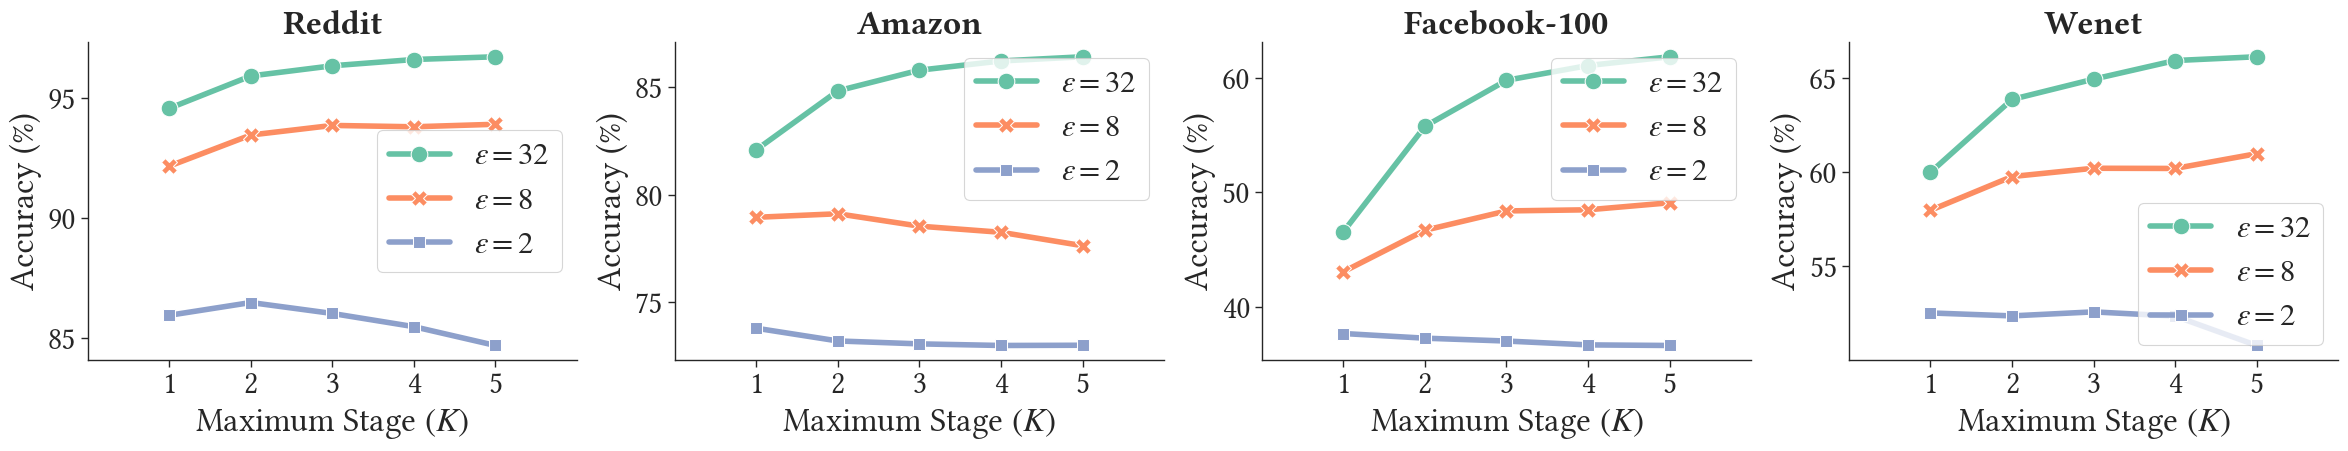

In [20]:
cols = ['method', 'dataset', 'epsilon', 'stages', 'layerwise', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-NDP']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']
epsilons = [2, 8, 32]

# epsilons_ndp = [4,16]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons)]
df = df.query('layerwise == False')
df['stages'] -= 1

# select best models based on valication accuracy
idx = df.groupby(['method', 'dataset', 'epsilon', 'stages'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
df['epsilon'] = df['epsilon']#.astype(int).astype(str)
df['style'] = df['method'].str.cat(df['epsilon'].astype(str), sep='-')

g = sns.relplot(kind='line', data=df, hue='style', y='test/acc_mean', x='stages', col='dataset', aspect=1.2,
                col_order=datasets, row_order=methods, markers=True, dashes=False, style='style', legend=False,
                facet_kws={'sharey': False, 'sharex': False}, errorbar=None)

g.set(ylabel='Accuracy (%)', xlabel='Maximum Stage $(K)$', xlim=(0,6), xticks=range(1,6))
for method, axes in zip(methods, g.axes):
    for dataset, ax in zip(datasets, axes):
        ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
        ax.legend(
            labels=[f'$\epsilon={eps:.0f}$' for eps in df.loc[(df['method'] == method) & (df['dataset'] == dataset), 'epsilon'].unique()],
            # loc=legend_loc.get((method, dataset), None),
        )
        # ax.set_ylabel(f'{method} Accuracy (%)')
        
# g.axes[0][0].set(ylim=(65,80))
# g.axes[0][1].set(ylim=(97,99.1)); # g.axes[0][1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# g.axes[0][2].set_ylim(70,85)
# g.axes[1][0].set_ylim(55,70)
# g.axes[1][1].set(ylim=(92,96))
# g.axes[1][2].set_ylim(76,82)


g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.fig.set_figwidth(14)
g.savefig('figs/stages-node.pdf')
# df

# Effect of the maximum degree

/idiap/temp/sajadmanesh/.tmp/ipykernel_17995/555832042.py:21: UserWarning: 
The markers list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  g = sns.relplot(kind='line', data=df, x='max_degree', y='test/acc_mean', hue='epsilon',


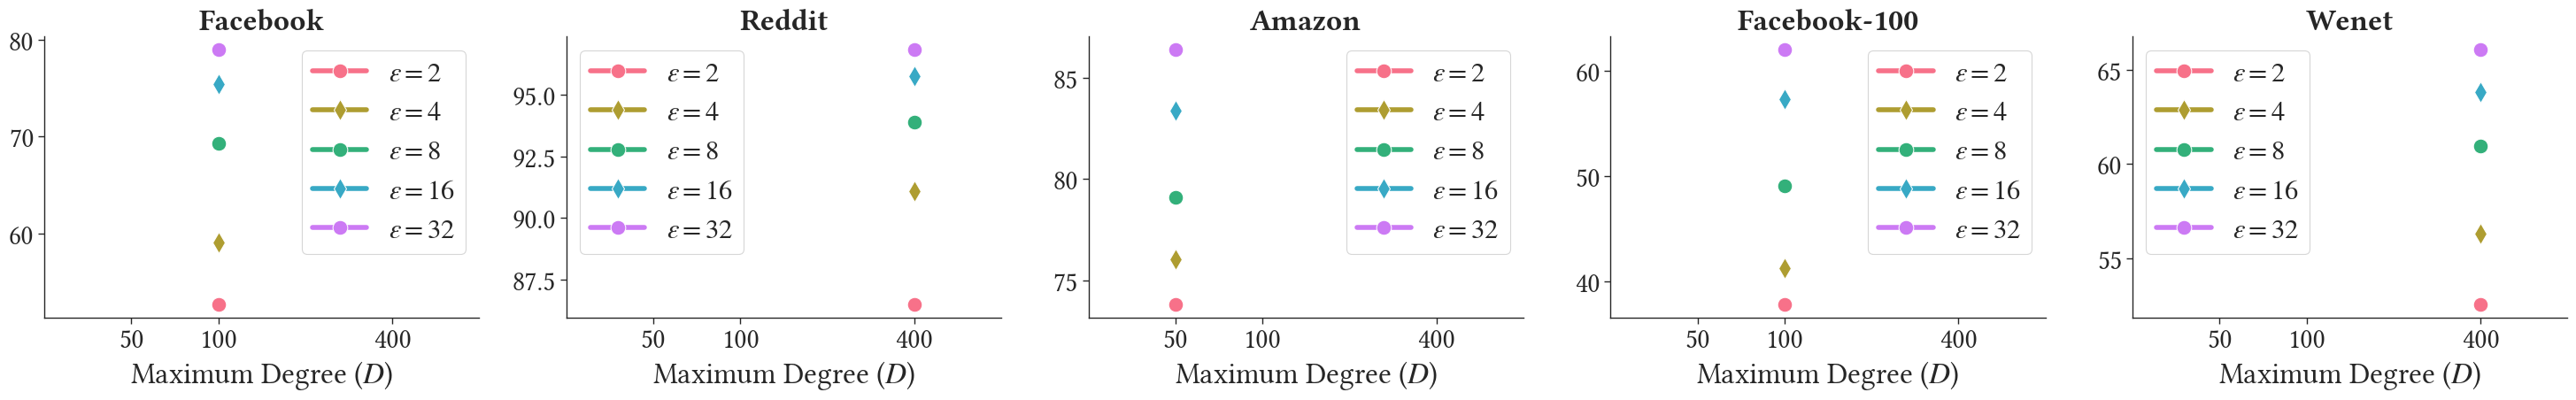

In [13]:
cols = ['method', 'dataset', 'epsilon', 'max_degree', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP-NDP']
datasets = ['facebook', 'reddit', 'amazon', 'facebook-100', 'wenet']
epsilons = [2,4,8,16,32]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df[df['method'].isin(methods)]
df = df[df['dataset'].isin(datasets)]
df = df[df['epsilon'].isin(epsilons)]

# select best models based on valication accuracy
idx = df.groupby(['method', 'dataset', 'epsilon', 'max_degree'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
epsilons = list(map(str, epsilons))
df['epsilon'] = df['epsilon'].astype(int).astype(str)

g = sns.relplot(kind='line', data=df, x='max_degree', y='test/acc_mean', hue='epsilon',
                col='dataset', aspect=1.2,
                col_order=datasets, 
                hue_order=epsilons, 
                markers=['o', 'd'], dashes=False, style='epsilon', legend=False, errorbar=None,
                facet_kws={'sharey': False, 'sharex': False})

degrees = df['max_degree'].unique()
degrees.sort()

g.set(xlabel='Maximum Degree ($D$)', ylabel=None, xscale='log', xticks=degrees, xlim=(degrees[0] / 2, degrees[-1] * 2))
for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    # ax.set_xticks(range(100,500,100))
    ax.legend(labels=[f"$\epsilon={eps}$" for eps in epsilons], ncol=1,)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()
        
# g.axes[0][0].set(ylim=(45,70), ylabel='ProGAP-NDP Accuracy (%)')
# g.axes[0][1].set_ylim(80,100)
# g.axes[0][2].set_ylim(73,81)

g.fig.subplots_adjust(hspace=0.5, wspace=0.2)
# g.fig.set_figwidth(14)
g.savefig('figs/degree.pdf')

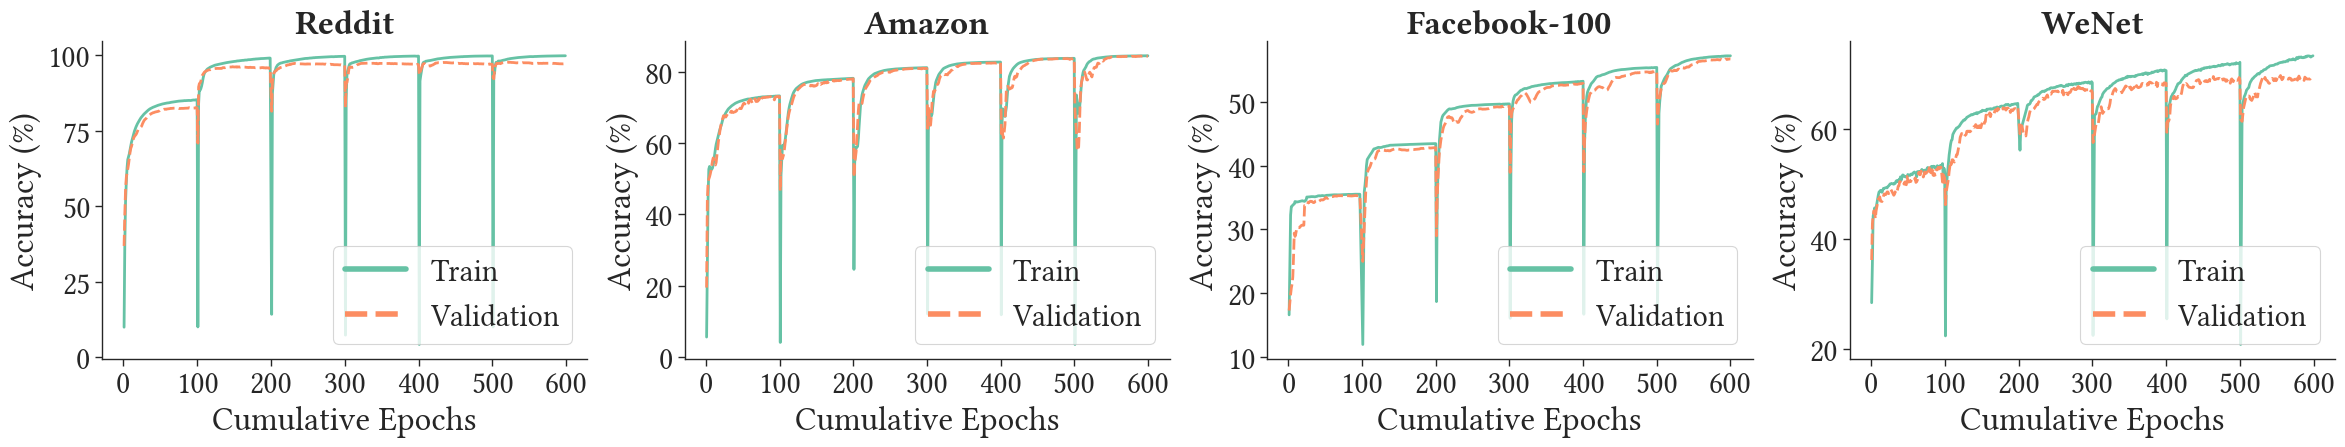

In [14]:
cols = ['id', 'method', 'dataset', 'train/acc_mean', 'val/acc_mean', 'run', 'log_all']
methods = ['ProGAP-EDP']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods and log_all == True')
df = df.dropna()
idx = df.groupby(['dataset', 'method'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df_history = pd.DataFrame()
for i, row in df.iterrows():
    df_run_history = row.run.history().filter(items=['_step', 'train/acc', 'val/acc'])
    df_run_history['_step'] += 1
    df_run_history['method'] = row.method
    df_run_history['dataset'] = row.dataset
    df_history = pd.concat([df_history, df_run_history], ignore_index=True)

df_history = df_history.melt(
    id_vars=['_step', 'method', 'dataset'],
    value_vars=['train/acc', 'val/acc'],
    var_name='metric',
)

df_history['metric'] = df_history['metric'].replace({
    'train/acc': 'Train',
    'val/acc': 'Validation',
})

g = sns.relplot(kind='line', data=df_history, x='_step', y='value', hue='metric', col='dataset', aspect=1.2,
                col_order=datasets, markers=False, dashes=True, style='metric',
                facet_kws={'sharey': False, 'sharex': False}, errorbar=None, linewidth=2)

g.set(ylabel='Accuracy (%)', xlabel='Cumulative Epochs', xticks=range(0,601,100))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label='WeNet' if dataset == 'wenet' else dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        loc='lower right', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=legend_data.values(), labels=legend_data.keys(),
        # labels=[method.replace('-NDP', '') for method in methods])
    )
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.axes[0][0].set_ylim(90, 100)
# g.axes[0][1].set_ylim(70, 100)
# g.axes[0][2].set_ylim(20, 80)
# g.axes[0][3].set_ylim(50, 80)
# g.fig.set_figwidth(16)
g.savefig('figs/convergence-edge.pdf')

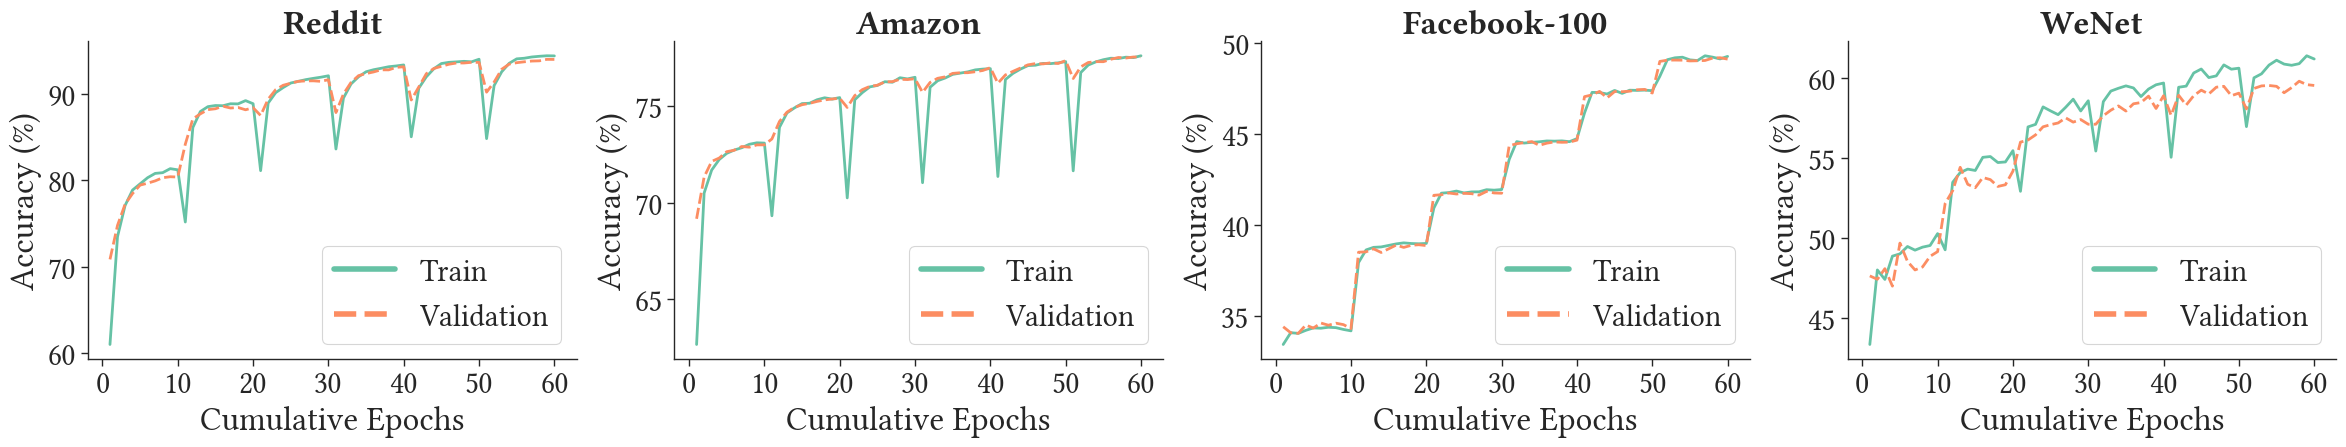

In [15]:
cols = ['id', 'method', 'dataset', 'train/acc_mean', 'val/acc_mean', 'run', 'log_all']
methods = ['ProGAP-NDP']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods and log_all == True')
df = df.dropna()
idx = df.groupby(['dataset', 'method'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df_history = pd.DataFrame()
for i, row in df.iterrows():
    df_run_history = row.run.history().filter(items=['_step', 'train/acc', 'val/acc'])
    df_run_history['_step'] += 1
    df_run_history['method'] = row.method
    df_run_history['dataset'] = row.dataset
    df_history = pd.concat([df_history, df_run_history], ignore_index=True)

df_history = df_history.melt(
    id_vars=['_step', 'method', 'dataset'],
    value_vars=['train/acc', 'val/acc'],
    var_name='metric',
)

df_history['metric'] = df_history['metric'].replace({
    'train/acc': 'Train',
    'val/acc': 'Validation',
})

g = sns.relplot(kind='line', data=df_history, x='_step', y='value', hue='metric', col='dataset', aspect=1.2,
                col_order=datasets, markers=False, dashes=True, style='metric',
                facet_kws={'sharey': False, 'sharex': False}, errorbar=None, linewidth=2)

g.set(ylabel='Accuracy (%)', xlabel='Cumulative Epochs', xticks=range(0,61,10))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label='WeNet' if dataset == 'wenet' else dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        loc='lower right', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=legend_data.values(), labels=legend_data.keys(),
        # labels=[method.replace('-NDP', '') for method in methods])
    )
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.axes[0][0].set_ylim(90, 100)
# g.axes[0][1].set_ylim(70, 100)
# g.axes[0][2].set_ylim(20, 80)
# g.axes[0][3].set_ylim(50, 80)
# g.fig.set_figwidth(16)
g.savefig('figs/convergence-node.pdf')